## CNN  en sepecifier une station

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import layers , callbacks,optimizers,models
import matplotlib.pyplot as plt

traite time serise data 

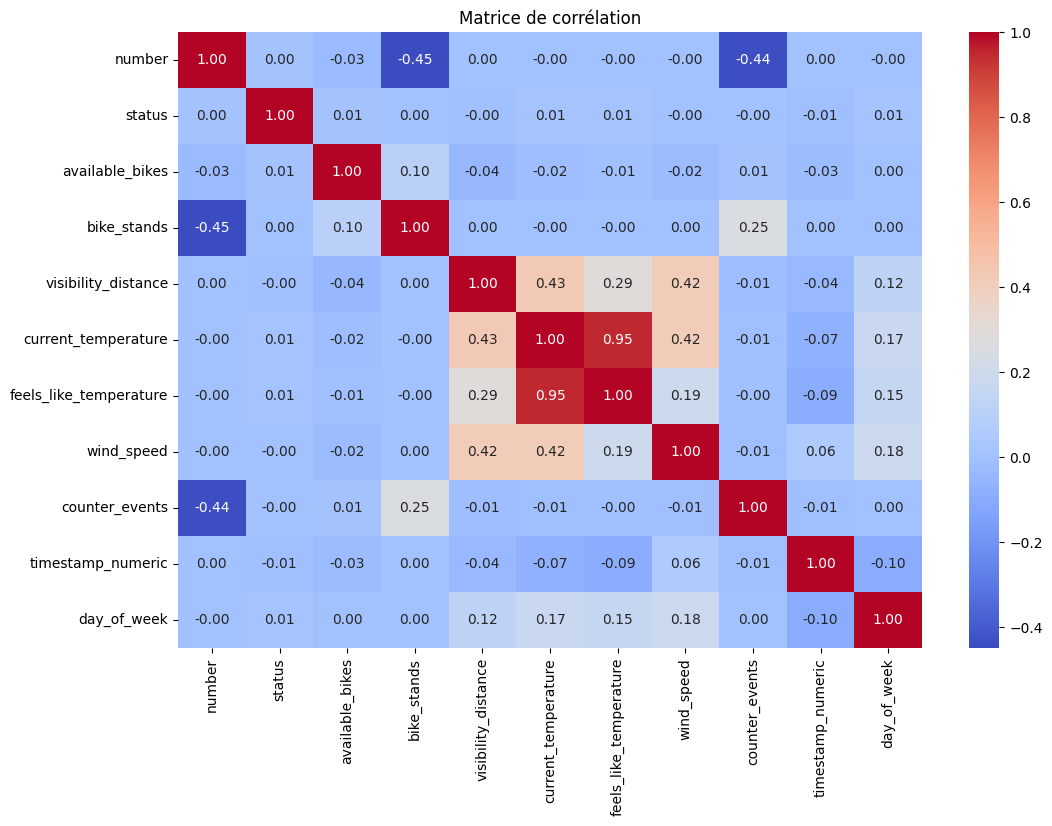

In [ ]:

from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold


file_path = '../data/merged_all_bikes_weather_events.csv'
data = pd.read_csv(file_path)
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['timestamp_numeric'] = data['timestamp'].astype('int64') // 10**9 ##en secondes UNIX
data['day_of_week'] = pd.to_datetime(data['timestamp']).dt.dayofweek
data = data.drop(columns=['timestamp','is_rainy','available_bike_stands'])


plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matrice de corrélation")
plt.show()

grouped = data.groupby('number')
group = grouped.get_group(44)  
##group=group.sort_index()

X = group.drop(columns=['available_bikes'])
y = group['available_bikes']
    
standardScale_feature=['status','visibility_distance','current_temperature','feels_like_temperature','wind_speed','counter_events','timestamp_numeric','day_of_week']

scaler_x = StandardScaler()
data_x_scaled = X.copy()
data_x_scaled[standardScale_feature] = scaler_x.fit_transform(X[standardScale_feature])
y_scaled = y.values.reshape(-1, 1)
x_scaled = data_x_scaled.values

#print(data_x_scaled.columns)



In [95]:
# Modèle cnn
def build_model(input_shape):
    model = models.Sequential([
        layers.Conv1D(32, kernel_size=2, activation='relu', padding='same', input_shape=(input_shape)),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(16, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='linear')
    ])
    optimizer = optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', 'mse']
    )
    return model

callback_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-5
    )
]



In [96]:
def taux_correct_predictions(y_test,y_pred,tolerance):
    correct_predictions = np.abs(y_test - y_pred) <= tolerance
    accuracy = np.mean(correct_predictions) * 100  # Convertir en pourcentage
    print(f"Le taux de précision correctes de test avec tolerance={tolerance}: {accuracy:.2f}%")

In [97]:

test_size = 0.2  # 20 % pour le test
val_size = 0.2   # 20 % pour validation


X_train_full, X_test, y_train_full, y_test = train_test_split(x_scaled, y_scaled, test_size=test_size, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=val_size, shuffle=True)

# Reshape pour CNN
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Vérification des formes
print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")
model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))

# Entraînement du modèle
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16,
    shuffle=True,
    callbacks=callback_list,
    verbose=1
)

# Prédictions sur l'ensemble de test
predictions = model.predict(X_test)
predictions = np.round(predictions).astype(int)
# Calcul des métriques pour l'ensemble de test
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)


# Calcul du MAPE (Mean Absolute Percentage Error)
non_zero_indices = y_test > 1e-3  # Éviter les divisions par zéro ou très petites valeurs
if non_zero_indices.sum() > 0:  # Vérifier qu'il y a des valeurs valides
    mape = np.mean(
        np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])
    ) * 100
else:
    mape = np.inf

taux_correct_predictions(y_test,predictions,0)
taux_correct_predictions(y_test,predictions,1)
taux_correct_predictions(y_test,predictions,2)

print(f"MAPE: {mape:.2f}%, MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

Train shape: (1995, 1, 10)
Validation shape: (499, 1, 10)
Test shape: (624, 1, 10)
Epoch 1/30


/Users/yongjiazeng/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 27.7132 - mae: 4.0466 - mse: 27.7132 - val_loss: 24.9465 - val_mae: 3.6437 - val_mse: 24.9465 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.3858 - mae: 3.3913 - mse: 21.3858 - val_loss: 18.4337 - val_mae: 3.1170 - val_mse: 18.4337 - learning_rate: 0.0010
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.4761 - mae: 2.9042 - mse: 15.4761 - val_loss: 12.3858 - val_mae: 2.7677 - val_mse: 12.3858 - learning_rate: 0.0010
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13.6871 - mae: 2.9238 - mse: 13.6871 - val_loss: 11.4297 - val_mae: 2.8135 - val_mse: 11.4297 - learning_rate: 0.0010
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.5782 - mae: 2.7912 - mse: 11.5782 - val_loss: 10.4517 - val_mae: 2.6590 - val_mse: 10.4517 - learning_rate: 0.0010
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.4367 - mae: 2.8107 - mse: 11.4367 - val_loss: 10.7638 - va

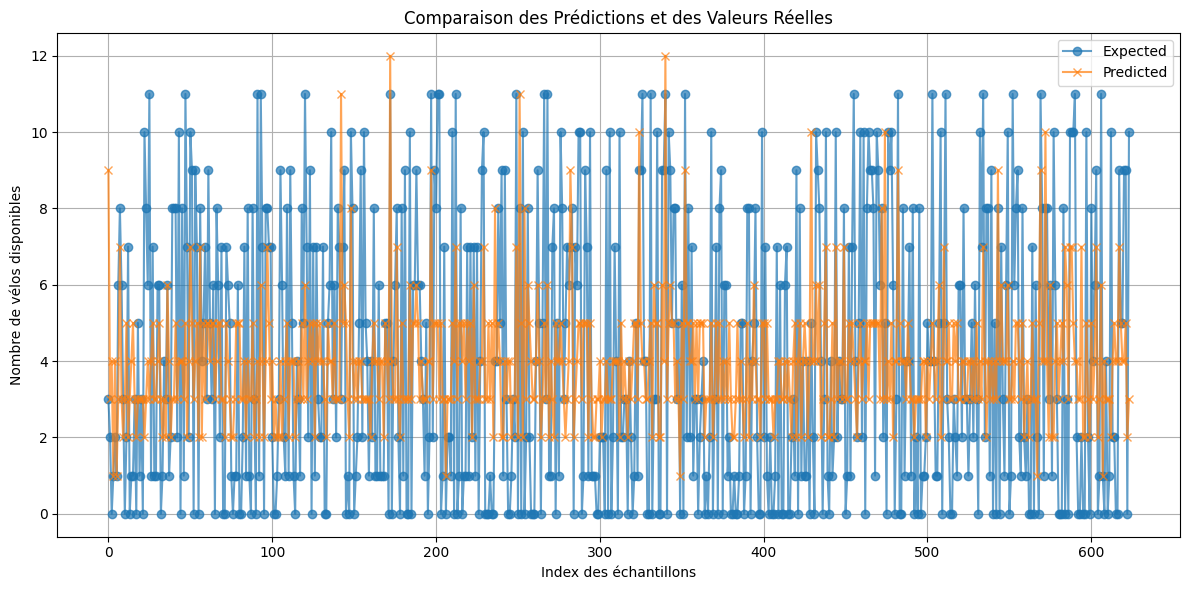

In [98]:
import matplotlib.pyplot as plt

# Tracer les résultats pour comparer les valeurs réelles et prédites
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Expected', linestyle='-', marker='o', alpha=0.7)
plt.plot(range(len(predictions)), predictions, label='Predicted', linestyle='-', marker='x', alpha=0.7)

# Ajout des détails au graphique
plt.title("Comparaison des Prédictions et des Valeurs Réelles")
plt.xlabel("Index des échantillons")
plt.ylabel("Nombre de vélos disponibles")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


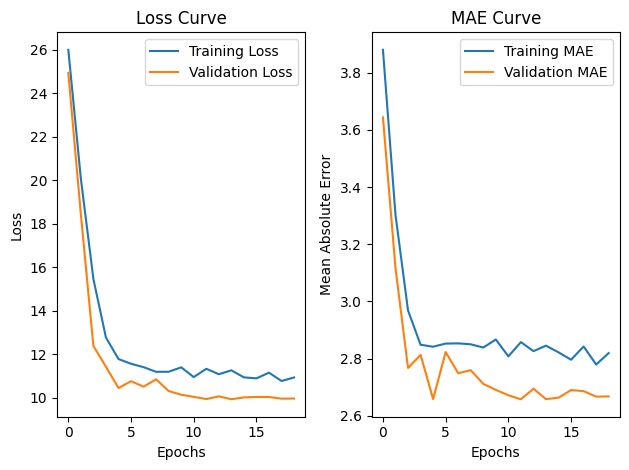

In [99]:
# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Courbe des métriques (MAE ici)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Curve')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

# export model scaler

In [100]:
from tensorflow.keras.models import load_model
import joblib

model.save('../models_for_cluster/cnn_model_for_cluster3.h5')
joblib.dump(scaler_x, '../scalers/scaler_X_cluster3.pkl') 


['scaler_X_cluster1.pkl']